In [101]:
%load_ext autoreload
%autoreload 2

import sys
import os

sys.path.append(os.path.abspath(".."))
from src.data_retrieval import scrape_pfr_rosters, load_seasonal_stats, load_rosters
from src.data_cleaning import numeric_col, basic_roster_info, merge_roster_data, sorted_playoffs_next
from src.modeling import (scatter_matrix_fn, labeled_2d_scatter,
                          labeled_hist, test_vif, fit_weighted_log,
                          rfe_features, lasso_coefficients, train_test_split,
                          confusion_matrix_and_classification_rep, threshold_tuning_plot)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# **Predicting NFL Playoff Teams Based on Previous Season Stats**

## 1. Introduction

This mini project began as a self-driven exercise as I was reading chapter 4 of "An Introduction to Statistical Learning" by James, Witten, Hastie, Tibshirani, and Taylor. The goal is to determine which rudimentary or team-level statistics (if any) from the previous NFL season can be used to predict whether or not a team will make the playoffs in the next season. This will broadly measure how success or failure in one season carries over to the next.

## 2. Data Sources and Arrangement

All data was obtained from Pro Football Reference (https://www.pro-football-reference.com/) for the regular seasons between 1990-2024. The data was collected in two stages and via two methods.

First, in my stubbornness and refusal to use web scraping, I manually copied and pasted the yearly team standings (see the AFC and NFC tables at https://www.pro-football-reference.com/years/2024/, for example) into a spreadsheet. I then manually changed the team names to reflect the current franchise abbreviations (e.g. 'Houston Oilers' and 'Tennessee Oilers' $\mapsto$ 'TEN' for the Tennessee Titans). To cap off this unnecessarily tedious endeavor, I added a column 'Playoffs' in which a 1 indicates a team made the playoffs that season and a 0 indicates they did not.

In [2]:
seasonal_stats = load_seasonal_stats("/Users/coledurham/Documents/nfl_playoff_predictor/data/Seasonal Stats - Season Stats.csv")
seasonal_stats.head()

,Tm,Season,W,L,T,win_percent,PF,PA,PD,MoV,SoS,SRS,OSRS,DSRS,Playoffs
0,BUF,2024,13,4,0,0.765,525,368,157,9.2,-1.1,8.1,7.8,0.3,1
1,MIA,2024,8,9,0,0.471,345,364,-19,-1.1,-1.9,-3.0,-3.5,0.4,0
2,NYJ,2024,5,12,0,0.294,338,404,-66,-3.9,-0.5,-4.3,-3.0,-1.4,0
3,NE,2024,4,13,0,0.235,289,417,-128,-7.5,-0.6,-8.1,-6.2,-1.9,0
4,BAL,2024,12,5,0,0.706,518,361,157,9.2,0.6,9.9,8.0,1.9,1


In the dataframe seasonal_stats, each row contains:


*   Tm: Team abbreviation
*   Season: Year of season
*   W, L, T: Wins, losses, and ties
*   win_percent: Win percentage
*   $PF$: Points for
*   $PA$: Points against
*   $PD$: Point differential, given by PF-PA
*   $MoV$: Average margin of victory, given by $\frac{PF-PA}{W+L+T}$
*   $SoS$: Strength of schedule
*   SRS: Simple rating system, given by $MoV+SoS$
*   OSRS/DSRS: Offensive and defensive ratings from the simple rating system
*   Playoffs: Binary variable indicating whether a team made the playoffs (1) or missed the playoffs (0)

win percentage, points for, points against, point differential (PF-PA), average margin ((PF-PA)/W+L+T), strength of schedule, simple rating (MoV+SoS), offensive simple rating, and defensive simple rating.

Next, to gain more information about each team and the constitution of their roster, I used the requests.get( ) method to scrape the roster page for each team in each season (see https://www.pro-football-reference.com/teams/buf/2024_roster.htm, for example). Of note in the scraping logic: 'BeautifulSoup' is used in conjunction with 'pandas.read_html' to extract the appropriate table from the page HTML; the team abbreviations used by PFR are converted to my preferred abbreviations using a dictionary.

In [3]:
#nfl_rosters = scrape_pfr_rosters(1990, 2025)
NFL_rosters = load_rosters("/Users/coledurham/Documents/nfl_playoff_predictor/data/NFL_rosters.csv")
NFL_rosters.head()

/Users/coledurham/Documents/nfl_playoff_predictor/src/data_retrieval.py:117: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[df["Yrs"] == "Rook", "Yrs"] = '0'


,Player,Year,Tm,Age,Pos,G,GS,Ht,Wt,College/Univ,BirthDate,Yrs,AV,Drafted (tm/rnd/yr)
0,Jim Bakken,1970,ARI,30.0,K,14,0.0,5-11,200.0,Wisconsin,11/2/1940,8.0,5.0,Los Angeles Rams / 7th / 88th pick / 1962
1,Pete Beathard,1970,ARI,28.0,QB,4,0.0,6-1,200.0,USC,3/7/1942,6.0,1.0,"Kansas City Chiefs / 1st / 2nd pick / 1964, De..."
2,Robert Brown,1970,ARI,27.0,TE,14,1.0,6-2,225.0,Alcorn St.,1/1/1943,1.0,0.0,NaN
3,Terry Brown,1970,ARI,23.0,DB,10,1.0,6-0,205.0,Oklahoma St.,1/9/1947,1.0,1.0,St. Louis Cardinals / 3rd / 73rd pick / 1969
4,Jerry Daanen,1970,ARI,26.0,WR,14,0.0,6-0,190.0,Miami (FL),12/15/1944,2.0,0.0,St. Louis Cardinals / 8th / 205th pick / 1968


In each row we see:
* No.: Jersey number
* Player: Name of player
* Year: Calendar year corresponding to the season
* Tm: Team, as previously
* Age: How old the player is in years
* Pos: Player position
* G: Games played
* GS: Games started
* Ht: Height, formatted as feet-inches
* Wt: Weight in pounds
* College/Univ: College(s) attended by the player
* BirthDate: Date on which player was born
* Yrs: Years the player has been in professional football
* AV: Average value, a metric produced by PFR for every player since 1960
* Drafted: Information regarding when the player was selected within the NFL draft

With regards to making or missing the playoffs next year, it is reasonable to expect the average age of the roster and the number of rookies this year to have an impact. For an overview of team composition among relevant players, we find the average age and experience of roster members who played in at least 8 games (approximately half the season irrespective of year), as well as the total number of rookies on the roster.

In [4]:
roster_makeup = basic_roster_info(NFL_rosters, 1990, 2025, 8)
roster_makeup.head()

,Year,Tm,Avg Age,Avg Experience,Num Rookies
0,1990,ARI,26.652174,3.717391,10
1,1990,ATL,26.227273,3.386364,8
2,1990,BUF,26.777778,3.511111,10
3,1990,CHI,26.782609,3.826087,12
4,1990,CIN,26.456522,3.565217,8


Next, we merge seasonal_stats and roster_makeup on the columns 'Tm', 'Season', and 'Tm', 'Year'; we then add a column 'playoffs_next_yr' by a group shift. This introduces 'NaN' entries in the year 2024, as the 2025 NFL season has yet to be played. These rows are dropped, and what remains is the data we will work with.

In [5]:
stats_sorted = sorted_playoffs_next(merge_roster_data(seasonal_stats, roster_makeup))
Data = stats_sorted[['win_percent', 'PF', 'PA', 'PD', 'SoS', 'SRS', 'OSRS', 'DSRS','Avg Experience', 'Avg Age', 'Num Rookies','Playoffs', 'playoffs_next_yr']].dropna()
Data.head()

,win_percent,PF,PA,PD,SoS,SRS,OSRS,DSRS,Avg Experience,Avg Age,Num Rookies,Playoffs,playoffs_next_yr
1079,0.313,268,396,-128,1.3,-6.7,-1.9,-4.8,3.717391,26.652174,10,0,0.0
1051,0.250,196,344,-148,3.8,-5.4,-4.9,-0.5,3.000000,25.977778,11,0,0.0
1023,0.250,243,332,-89,2.5,-3.1,-2.9,-0.1,3.681818,26.522727,9,0,0.0
994,0.438,326,269,57,0.4,3.9,1.9,2.1,4.785714,27.547619,9,0,0.0
965,0.500,235,267,-32,-0.3,-2.3,-5.6,3.3,3.869565,26.521739,14,0,0.0


Note that we drop the columns 'W', 'L', and 'T' in favor of just 'win_percent' since it contains the same information. We also drop 'Year' because while the percentage of teams to make the playoff has fluctuated over time due to changes in format and total number of teams, it has only ever ranged between 37.5% (2002-2019) and 43.8% (2020-2024).

## 3. Descriptive Statistics

To get a sense of how our features relate to one another, we first look at the correlation matrix for the data and the corresponding scatter matrix.

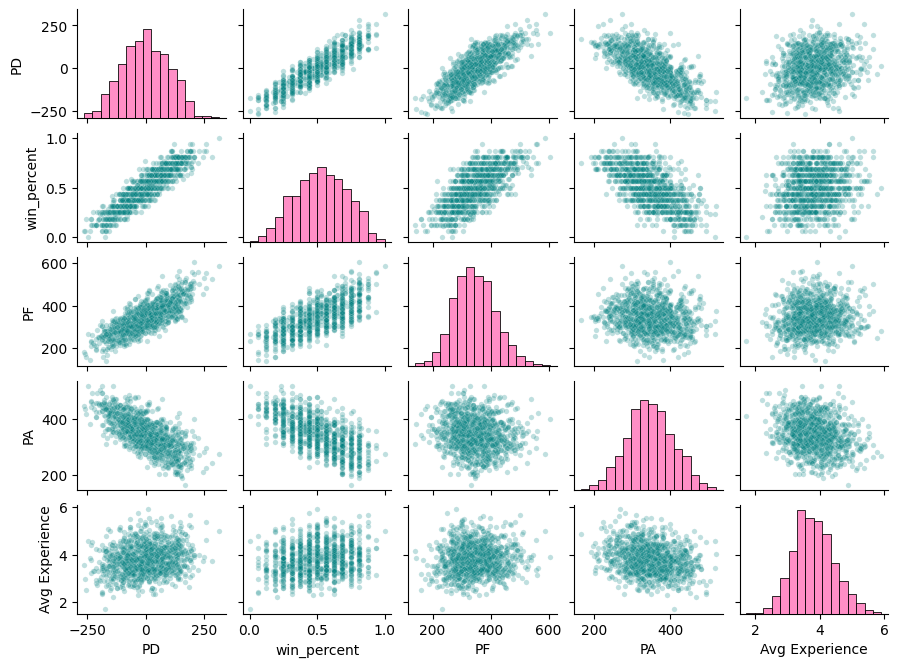

In [27]:
scatter_matrix_fn(Data, ['PD', 'win_percent', 'PF', 'PA', 'Avg Experience'])


In [28]:
Data[Data.columns.drop('playoffs_next_yr').to_list()].corr()

,win_percent,PF,PA,PD,SoS,SRS,OSRS,DSRS,Avg Experience,Avg Age,Num Rookies,Playoffs
win_percent,1.000000,0.717406,-0.652709,0.910952,-0.231388,0.877805,0.732139,0.647015,0.181465,0.154343,-0.321213,0.780707
PF,0.717406,1.000000,-0.133908,0.799810,-0.205059,0.769534,0.923178,0.222584,0.088090,0.047272,-0.194280,0.557122
PA,-0.652709,-0.133908,1.000000,-0.701949,0.143670,-0.685234,-0.258685,-0.887871,-0.238931,-0.243984,0.319154,-0.509301
PD,0.910952,0.799810,-0.701949,1.000000,-0.234398,0.968116,0.820177,0.697762,0.208033,0.181757,-0.332943,0.708892
SoS,-0.231388,-0.205059,0.143670,-0.234398,1.000000,0.015971,-0.038136,0.074883,-0.015907,-0.016416,0.039844,-0.210244
SRS,0.877805,0.769534,-0.685234,0.968116,0.015971,1.000000,0.833602,0.737359,0.209682,0.182619,-0.332351,0.675124
OSRS,0.732139,0.923178,-0.258685,0.820177,-0.038136,0.833602,1.000000,0.241634,0.174605,0.156998,-0.279162,0.564029
DSRS,0.647015,0.222584,-0.887871,0.697762,0.074883,0.737359,0.241634,1.000000,0.155240,0.129380,-0.242655,0.496217
Avg Experience,0.181465,0.088090,-0.238931,0.208033,-0.015907,0.209682,0.174605,0.155240,1.000000,0.953852,-0.527433,0.105981
Avg Age,0.154343,0.047272,-0.243984,0.181757,-0.016416,0.182619,0.156998,0.129380,0.953852,1.000000,-0.501493,0.086277


Some correlation coefficients in the above table/matrix are expected, but of note. First, win_percent and PD have a strong, positive correlation. Unsurprisingly, PD has reasonably strong correlation with PF and PA, though it is interesting that it has a slightly more positive correlation with PF than negative correlation with PA. These connections will be further explored when determining features to keep in the model(s).

Next, we make several plots which show if any features are split into distinct regimes by the label 'playoffs_next_yr'. For instance, if a team has a strong win percentage this year, how likely is that success to be retained?

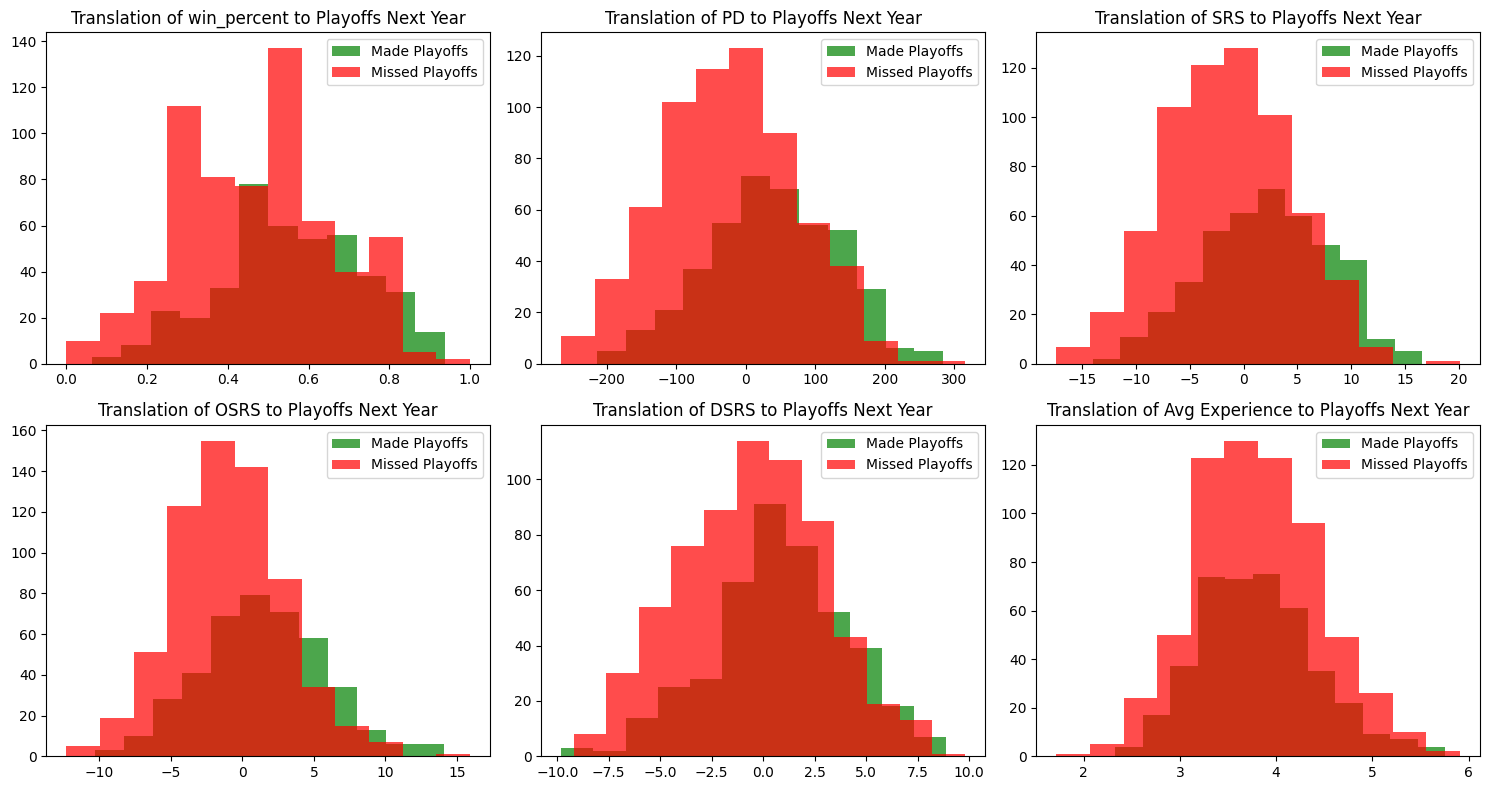

In [34]:
labeled_hist(Data, cols=['win_percent', 'PD', 'SRS','OSRS', 'DSRS', 'Avg Experience'])

The above plots suggest that no single predictor separates the data, as expected. We can make two-dimensional plots of a similar flavor in hopes of seeing greater separation.

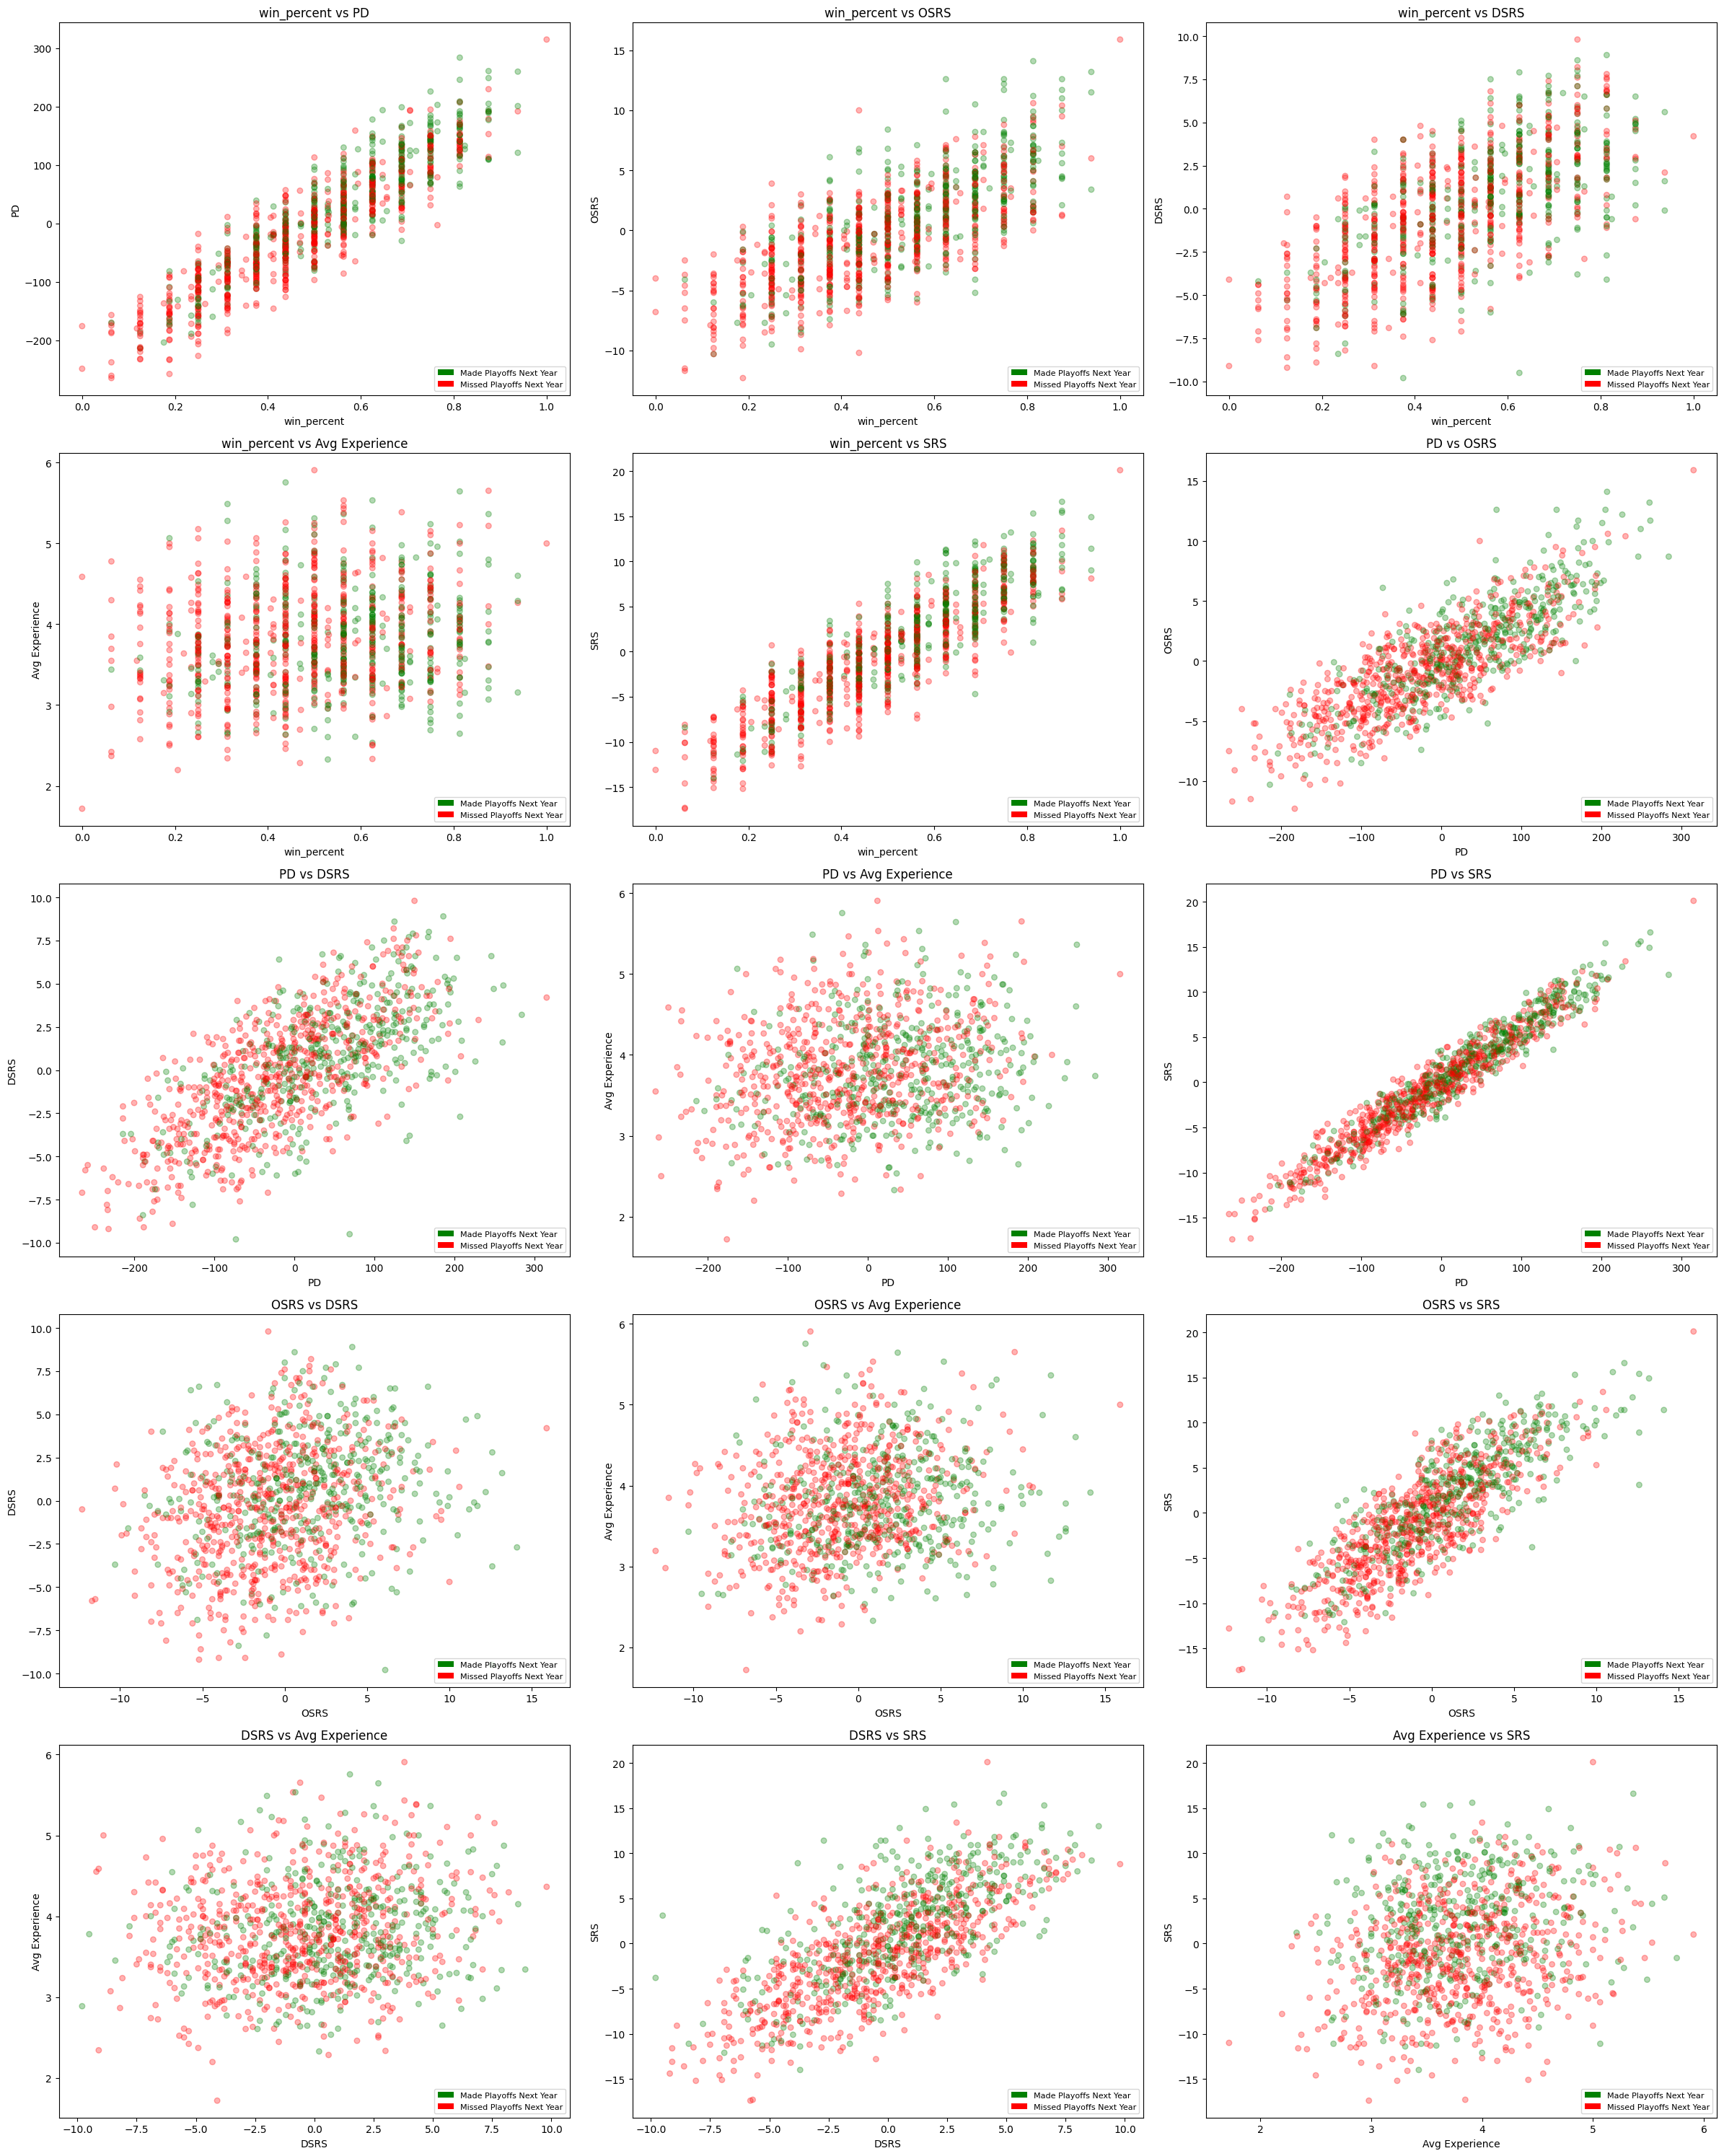

In [46]:
labeled_2d_scatter(Data, ['win_percent', 'PD', 'OSRS', 'DSRS', 'Avg Experience', 'SRS'], alpha=0.3)

This collection of plots further illustrates the noisy relationship between statistics one year and making the playoffs the next year. However, it does visually indicate (by densities of red versus green dots) some improved separation of the data compared to single-feature plots.

## 4. Logistic Regression Model

In this section we train and test a logistic regression model using the 'statsmodels' module, but to start we will eliminate certain features which cause significant multicollinearity. Specifically, we use the variance inflation factor (VIF) to determine a subset of features.

In [56]:
features = Data.columns.drop(['playoffs_next_yr'])
X_full = Data[features]
y = Data['playoffs_next_yr']

test_vif(X_full)

/Users/coledurham/Documents/nfl_playoff_predictor/env39/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,feature,VIF
0,win_percent,6.013943e+01
1,PF,inf
2,PA,inf
3,PD,inf
4,SoS,2.135018e+02
5,SRS,1.492486e+04
6,OSRS,6.804309e+03
7,DSRS,4.569583e+03
8,Avg Experience,8.986354e+01
9,Avg Age,4.599508e+02


From this table, we see that many of our features can be eliminated even before we run any feature elimination algorithms. Indeed as is known, PF and PA completely determine PD. We retain Playoffs, Avg Experience, SoS, Playoffs, OSRS, and PD. (Note PD is retained since it is correlated with win percentage and demonstrates higher predictive significance. OSRS is retained over DSRS for the time being because offensive strnegth is generally viewed as more consistent than defensive strength from year to year.)

In [76]:
features_reduced = ['PD', 'Playoffs', 'OSRS', 'Avg Experience', 'SoS']
X_0 = Data[features_reduced]
test_vif(X_0)

,feature,VIF
0,PD,4.434045
1,Playoffs,3.161190
2,OSRS,3.311407
3,Avg Experience,2.195901
4,SoS,1.150178


With a smaller feature set and more respectable VIF, we split the data into training and testing sets and fit a baseline model with the reduced feature set. 

In [91]:
X_0_train, X_0_test, y_train, y_test = train_test_split(X_0, y, test_size=0.2,
                                                         stratify=y, random_state=42)
model_0_results = fit_weighted_log(X_0_train, y_train).summary()
model_0_results


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:       playoffs_next_yr   No. Observations:                  845
Model:                            GLM   Df Residuals:                   840.00
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -541.76
Date:                Tue, 22 Jul 2025   Deviance:                       1083.5
Time:                        18:10:37   Pearson chi2:                     845.
No. Iterations:                     4   Pseudo R-squ. (CS):            0.09878
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
PD                 0.0050      0.002      3.212      0.001       0.002       0.008
Playoffs           0.0288      0.199      0.145      0.885      -0.361       0.419
OSRS               0.0542      0.032      1.717      0.086      -0.008       0.116
Avg Experience    -0.0222      0.028     -0.804      0.421      -0.076       0.032
SoS                0.0500      0.050      0.994      0.320      -0.049       0.149
==================================================================================
"""

Some immediate (tentative) takeaways:

- PD is most significant based on $p$-statistic, while somewhat surprisingly Playoffs is least significant in the same regard.

- OSRS is nearly significant (typically $p<0.05$ is considered significant). It may have reduced impact due to correlation with PD.

We perform recursive feature elimination to determine which set of 3 predictors will capture the most signal. We also run Lasso logistic regression for the same purpose, and compare the results.

In [83]:
rfe = rfe_features(X_0_train, y_train, 3)
print(rfe)

['PD', 'OSRS', 'Avg Experience']


In [85]:
lasso_output = lasso_coefficients(X_0_train, y_train)
print(lasso_output)

PD                0.546709
Playoffs         -0.025043
OSRS              0.239717
Avg Experience   -0.167489
SoS               0.087022
dtype: float64


These two methods yield similar results. PD is indeed the most impactful predictor, with OSRS and Avg Experience following. We fit a new model with these features.

In [96]:
X_1 = X_0[['PD', 'OSRS', 'Avg Experience']]
X_1_train, X_1_test, y_train, y_test = train_test_split(X_1, y, test_size=0.2,
                                                         stratify=y, random_state=42)
model_1 = fit_weighted_log(X_1_train, y_train)
model_1_results = model_1.summary()
model_1_results

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:       playoffs_next_yr   No. Observations:                  845
Model:                            GLM   Df Residuals:                   842.00
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -542.26
Date:                Tue, 22 Jul 2025   Deviance:                       1084.5
Time:                        18:13:46   Pearson chi2:                     845.
No. Iterations:                     4   Pseudo R-squ. (CS):            0.09772
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
PD                 0.0047      0.001      3.611      0.000       0.002       0.007
OSRS               0.0625      0.030      2.053      0.040       0.003       0.122
Avg Experience    -0.0188      0.019     -0.996      0.319      -0.056       0.018
==================================================================================
"""

In [100]:
permormance_metrics = confusion_matrix_and_classification_rep(model_1, X_1_test, y_test=y_test)
print(permormance_metrics[0])
print(permormance_metrics[1])

[[87 41]
 [34 50]]
              precision    recall  f1-score   support

         0.0      0.719     0.680     0.699       128
         1.0      0.549     0.595     0.571        84

    accuracy                          0.646       212
   macro avg      0.634     0.637     0.635       212
weighted avg      0.652     0.646     0.648       212



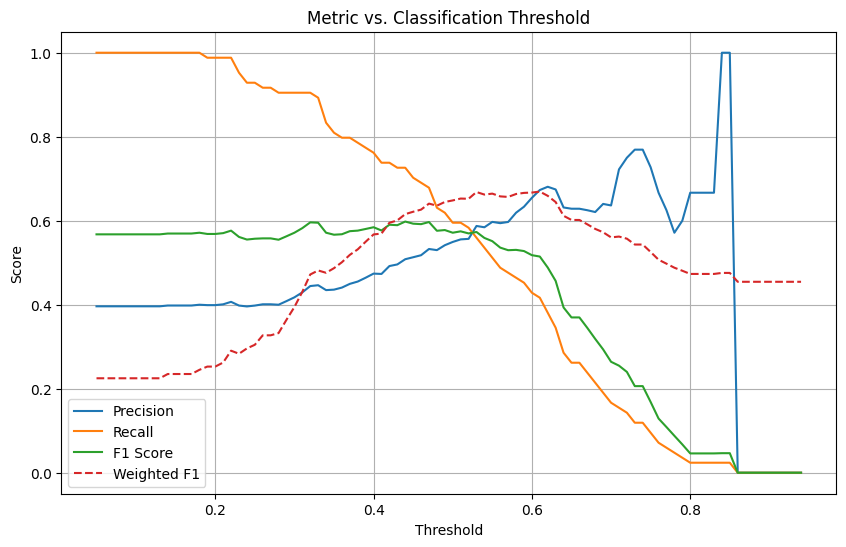

In [102]:
threshold_tuning_plot(y_test,model_1.predict(X_1_test))